# Exploratory Data Analysis

In [19]:
import sys
sys.path.append('/Users/efraflores/Desktop/hub/asimov_generator/venv/lib/python3.9/site-packages')

## Parameters

In [20]:
import os

BASE_DIR = '/Users/efraflores/Desktop/EF/Diplo/Asimov' #'/content' if you're using GColab
print(os.listdir(BASE_DIR))
SPLIT_PATTERN = "[\,\.\?\!\n]"#"[\.\?\!]" #How you want to split your text into sentences
EMBEDDING_DIM = 300 #from (50,100,200,300) possible embeddings with GloVe

['glove.6B.300d.txt', 'asimov_features.csv', '.DS_Store', 'glove.6B.100d.txt', 'corpus.txt', 'glove.6B.50d.txt', 'rnn_asimov_weights.h5', 'project', 'glove.6B.200d.txt', 'doc', 'rnn_asimov_architecture.json', 'glove.6B.zip', 'rnn_asimov_tokenizer.pickle', 'The_Last_Question.pdf']


## Functions

### Timing and tone

In [21]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

### Clean text

In [22]:
#Uncomment the following lines if it's the first time you run this packages
'''
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
'''
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def clean_text(text,
               language='english',pattern="[^a-zA-Z'\s]",
               lower=False,lemma=False,rem_stopw=False,unique=False,
               add_stopw=[]):
    #It clean and can remove stopwords or even lemmatize words if specified in params
    cleaned_text = unicodedata.normalize('NFD',str(text).replace('\n',' \n ')).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern,' ',cleaned_text.decode('utf-8'),flags=re.UNICODE)
    cleaned_text = [(lem.lemmatize(word,pos='v') if lemma else word) for word in 
                    (cleaned_text.lower().split() if lower else cleaned_text.split())]
    if rem_stopw: cleaned_text = [word for word in cleaned_text if word not in 
                                  stopwords.words(language)+add_stopw]
    return ' '.join((set(cleaned_text) if unique else cleaned_text))

#Ex
ex = "I am going to run!!! I ran while I was running??? ..."
print('\nOriginal:\t\t',ex)
print('Basic cleaning:\t\t',clean_text(ex))
print('Changing the pattern:\t',clean_text(ex,pattern="[^a-zA-Z!\.]"))
print('Without stopwords:\t',clean_text(ex,rem_stopw=True))
print('Lower and lemma:\t',clean_text(ex,lower=True,lemma=True))
print('Super cleaning:\t\t',clean_text(ex,add_stopw=['go'],lower=True,rem_stopw=True,lemma=True,unique=True))
print("\nIt actually corrects the weird accents, example\n\tFROM:\t ThÈ ÉfrâïsMã's?...\n\tTO:\t",clean_text("ThÈ ÉfrâïsMa's?...",lower=True))


Original:		 I am going to run!!! I ran while I was running??? ...
Basic cleaning:		 I am going to run I ran while I was running
Changing the pattern:	 I am going to run!!! I ran while I was running ...
Without stopwords:	 I going run I ran I running
Lower and lemma:	 i be go to run i run while i be run
Super cleaning:		 run

It actually corrects the weird accents, example
	FROM:	 ThÈ ÉfrâïsMã's?...
	TO:	 the efraisma's


### Sentiment

In [23]:
from nltk import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment(text):
    sid = SentimentIntensityAnalyzer()
    try:
        list(map(sid.polarity_scores,sent_tokenize(text)))[0]
    except:
        sentences = sent_tokenize('a')
    else:
        sentences = sent_tokenize(text)
    res = map(sid.polarity_scores, sentences)
    return list(res)[0]

print(sentiment('I love it'))
print(sentiment('I hate it'))
print(sentiment('It is ok'))

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}
{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.296}


### Transfer Embedding

The tutorial for Transfer Embedding is right here!

<https://keras.io/examples/nlp/pretrained_word_embeddings/>

If you're running this in GColab, uncomment the following lines to unzip the GloVe embeddings

(more info about GloVe at <https://nlp.stanford.edu/projects/glove/)>

but if you're working locally, move the files from the zip to your base_dir

In [24]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

'''!wget http://nlp.stanford.edu/data/glove.6B.zip 
!unzip -q glove.6B.zip'''

def transfer_embedding(base_dir,fitted_tokenizer,embedding_dim_out):
    #Get the pre-trained vectors as a dict
    emb_dict = {}
    with open(os.path.join(base_dir,f'glove.6B.{embedding_dim_out}d.txt')) as f:
        for line in f:
            #Each line is a word with its coef sep by \s
            word, coefs = line.split(maxsplit=1)
            #Like .split() transforming strings into an array
            coefs = np.fromstring(coefs,'f',sep=' ')
            #Update the dict with a new word and its coef
            emb_dict[word] = coefs
    #Keep track of the not-found words
    misses = []
    #Build a matrix full of zeros
    total_words = fitted_tokenizer.word_index
    words_matrix = np.zeros((len(total_words),embedding_dim_out))
    #Loop over the words-indexes...
    for word, i in total_words.items():
        #... to get its pre-trained value
        try: word_vector = emb_dict[word]
        #Some words won't be found, keep the zeros-vector
        except: misses.append(word)
        #Finally, transfer the pre-trained vector
        else: words_matrix[i-1] = word_vector
    print(f'Transfered {"{:.1%}".format(1-len(misses)/len(total_words))}% of {len(total_words)} words, just {len(misses)} were not found.')
    #Returns the dict_index of every word and other dict with its embedding
    return total_words,dict(zip(total_words.keys(),words_matrix)),misses

### WordCloud

In [25]:
import re
from PIL import Image
from wordcloud import WordCloud

def get_wordcloud(text,image_dir,image_name,n_title=20,repeat=False):
    #Show image
    def plot_data(data):
      plt.imshow(data, interpolation='nearest')
      plt.show()   
    #Import image    
    orig = Image.open(os.path.join(image_dir,image_name))
    plot_data(np.array(orig))
    #Adjust to RGB if the image is PNG
    img = Image.new('RGB', orig.size, (255,255,255))
    try: img.paste(orig,orig)
    except: pass
    finally: mask = np.array(img) #Make the image to data (RGB values as array)
    wordcloud = WordCloud(mask=mask,
                          font_path='/System/Library/Fonts/Supplemental/Impact.ttf',
                          color_func=lambda *args, **kwargs: 'white', #white letters
                          include_numbers=True,
                          prefer_horizontal=0.83, #percentage of horizontal words
                          background_color='black', 
                          max_words=100,
                          max_font_size=73,
                          repeat=repeat)
    #Get just the image name (without ext like png, jpg, jpeg, tiff)
    image_name = re.findall('^(\S+)\.(?=png|jpeg|jpg|tiff)',image_name)[-1]
    #Use the text provided and repeat the image name in order to display it in the wordcloud
    wordcloud.generate(text+' '.join([image_name.replace('_','-')]*n_title)
                       #And save it as a png
                      ).to_file(os.path.join(image_dir,f'WP_{image_name}.png')) 
    #Then call it again
    wordcloud = Image.open(os.path.join(image_dir,f'WP_{image_name}.png')).convert('RGBA')
    datas = wordcloud.getdata()
    #If the color is not white (letters) the pixel becomes transparent
    wordcloud.putdata([(255,255,255,0) if x[0]==x[1]==x[2]!=255 else x for x in datas])
    #Original image is pasted so just in the letters pixels is displayed (as from behind)
    wordcloud.paste(orig, box=(0,0), mask=wordcloud)
    #Save the Wordcloud and show it
    wordcloud.save(os.path.join(image_dir,f'WP_{image_name}.png'))
    display(wordcloud)

### K-clusters

In [37]:
'''!pip install pygal'''
import pygal
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

def koptimo(df):
    sse,db,slc = {}, {}, {}
    for k in range(2, 16):
        kmeans = KMeans(n_clusters = k, max_iter= 100, random_state = 22).fit(df)
        if k == 3: labels = kmeans.labels_
        clusters = kmeans.labels_
        sse[k] = kmeans.inertia_ 
        db[k] = davies_bouldin_score(df, clusters)
        slc[k] = silhouette_score(df, clusters)

    dicts = [sse,db,slc]

    for dicc in dicts:
        min_value = min(list(dicc.values()))
        max_value = max(list(dicc.values()))
        for k in dicc.keys():
            dicc[k] = (dicc[k] - min_value + 1)/(max_value - min_value + 1)

    line_chart = pygal.Line()
    line_chart.title = 'K-óptimo'
    line_chart.x_labels = map(str, sse.keys())
    for name, dicc in zip(['Inertia','DB','Silhouette'],dicts):
        line_chart.add(name, list(map(lambda x: round(x,2), dicc.values())))
    display(line_chart)
    return line_chart

### Clustering

In [27]:
'''!pip install seaborn'''
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

def clustering(df,
               cols,
               n_clusters=5,
               kmeans=False):
    df = df.copy()
    mm_df = MinMaxScaler()
    Xs = pd.DataFrame(mm_df.fit_transform(df[cols]), 
                      index = df.index,
                      columns = cols)
    
    cluster = (KMeans(n_clusters, random_state=22) if kmeans 
               else GaussianMixture(n_clusters, random_state=22))
    Xs['cluster'] = cluster.fit_predict(Xs)
    
    dict_cluster = dict(enumerate(string.ascii_uppercase[:n_clusters]))
    df['cluster'] = Xs['cluster'].map(dict_cluster) 
    print(f'Distribución de registros en los {n_clusters} clústeres')
    display(df['cluster'].value_counts(1).reset_index().sort_values(by='index'))

    pca = PCA(2)
    pipe_pca = Pipeline(steps=[('MinMax', mm_df),('PCA', pca)])
    Xg = pd.DataFrame(pipe_pca.fit_transform(df.iloc[:,:-1]), 
                      index = df.index,
                      columns = ['p1','p2'])
    Xg['cluster'] = df['cluster'].copy()
    print(f'Varianza explicada con 2dim: {"{:.1%}".format(pca.explained_variance_ratio_.sum())}')
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=Xg.sort_values(by='cluster'),
                    x='p1',
                    y='p2',
                    alpha=0.5,
                    hue='cluster', 
                    palette = 'Paired')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show();
    
    return df

### Profiles

In [28]:
def perfilamiento(df,cols=None,cluster='cluster'):
    n_clusters = len(set(df[cluster]))
    
    if cols==None:
        cols=df.columns
        aux = df[cols].groupby(cluster).mean()
        #aux = aux.transpose()
        for col in aux.columns:
            aux[col] /= aux[col].sum()

        fig = plt.figure()
        fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(aux.columns)/3))))
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.9)
        sns.heatmap(aux.transpose(),cmap='Blues')
        plt.show();
        
    else:
        for col in cols:
            aux = df.copy()
            aux['n'] = 1
            aux = aux.pivot_table(index=cluster,
                                  columns=col,
                                  values='n',
                                  aggfunc='count',
                                  fill_value=0)
            for columna in aux.columns:
                aux[columna] /= aux[columna].sum()

            fig = plt.figure()
            fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(set(df[col]))/4))))
            fig.patch.set_facecolor('white')
            fig.patch.set_alpha(0.9)
            sns.heatmap(aux.transpose(), cmap = 'Blues')
            plt.show();

## Transform

### Sentences

In [29]:
with open(os.path.join(BASE_DIR,'corpus.txt')) as txt:
    #Make sentences with the split-pattern provided and return just the non-empty sentences
    corpus = [x for x in re.split(SPLIT_PATTERN,txt.read()) if len(x)>0]
    
print(corpus[:2])

['"The Last Question By Isaac Asimov  This is by far my favorite story of all those I have written', '  ']


### Features

In [30]:
import pandas as pd
df = pd.DataFrame(corpus,columns=['sentence'])
df['clean'] = df['sentence'].apply(lambda x: clean_text(x,lower=True,pattern="[^a-zA-Z\s]"))
df['min_text'] = df['sentence'].apply(lambda x: clean_text(x,lower=True,lemma=True,pattern="[^a-zA-Z\s]",
                                                           rem_stopw=True,unique=True)+' a')
df['length'] = df['clean'].apply(len)
df['relevance'] = df['min_text'].apply(len) / (df['length']+1e-10)
df = df.join(pd.DataFrame(list(map(sentiment,df['clean']))))
df.sample(4)

,sentence,clean,min_text,length,relevance,neg,neu,pos,compound
123,about,about,a,5,0.400000,0.0,1.0,0.0,0.0000
33,t computer,t computer,computer a,10,1.000000,0.0,1.0,0.0,0.0000
913,Unhappily,unhappily,unhappily a,9,1.222222,1.0,0.0,0.0,-0.4404
957,too,too,a,3,0.666667,0.0,1.0,0.0,0.0000


### WordCloud

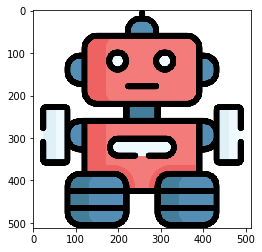

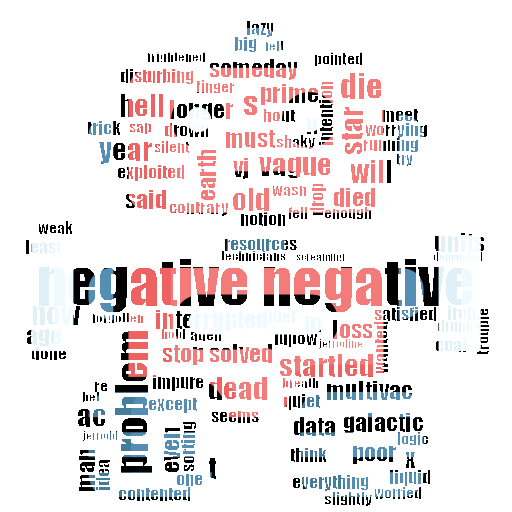

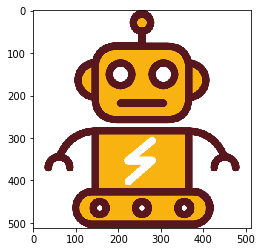

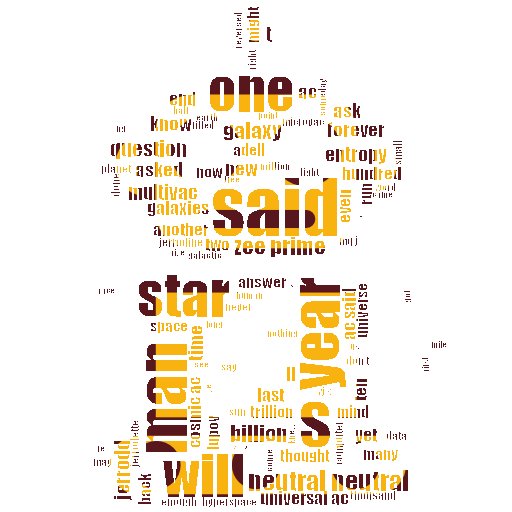

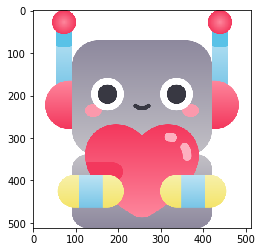

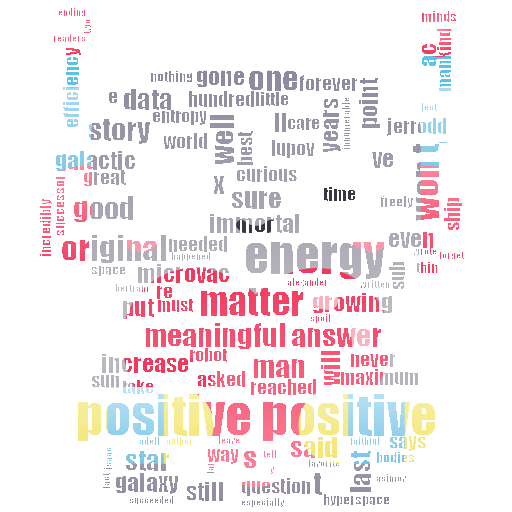

In [31]:
img_dir = os.path.join(BASE_DIR,'doc','images')
sentim = [df['compound']<0,df['compound']==0,df['compound']>0]
for i,image in enumerate(['negative.png','neutral.png','positive.png']):
    full_text = ' '.join(df[sentim[i]]['clean'])
    try: get_wordcloud(full_text,img_dir,image)
    except: pass

### Embedding

In [32]:
#Tokenize the words to feed the ANN
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['min_text'])
total_words,words_matrix,missed_words = transfer_embedding(BASE_DIR,tokenizer,EMBEDDING_DIM)
print(missed_words)

Transfered 94.0%% of 963 words, just 58 were not found.
['jerrodd', 'lupov', 'microvac', 'jerrodine', 'jerrodette', 'visiplate', 'hyperspatial', 'cellufilm', 'correcti', 'glor', 'vacati', 'originall', 'individu', 'lupow', 'thinki', 'insufficien', 'obbing', 'centere', 'jerrodettes', 'insideoutness', 'rrodd', 'lengt', 'squa', 'nement', 'etary', 'anci', 'rth', 'planetarv', 'whis', 'pered', 'rodette', 'crovac', 'agai', 'insuficient', 'lameth', 'nicron', 'infi', 'possi', 'fteen', 'eath', 'gaiaxy', 'geomet', 'ooner', 'somethi', 'submesons', 'univer', 'ndering', 'tlme', 'laxy', 'interste', 'llar', 'matons', 'dimmi', 'predecesors', 'tlmes', 'concei', 'vable', 'demonstrati']


In [33]:
from sklearn.decomposition import PCA

for perc in range(10,100,10):
    aux = df['min_text'].apply(lambda row:np.percentile(np.array([words_matrix[x]
                                                                  for x in row.split()]),
                                                        perc,axis=0))
    aux = pd.DataFrame(aux)
    aux = pd.DataFrame(aux['min_text'].to_list())
    aux = pd.DataFrame(PCA(.9).fit_transform(aux))
    df=df.join(aux.rename(columns={x:str(perc)+'_'+str(x).zfill(2) for x in aux.columns}))

In [34]:
df = df.set_index(['clean','min_text']).drop(columns=['sentence'])
df.sample()

,,length,relevance,neg,neu,pos,compound,10_00,10_01,10_02,10_03,...,90_79,90_80,90_81,90_82,90_83,90_84,90_85,90_86,90_87,90_88
clean,min_text,,,,,,,,,,,,,,,,,,,,,
zee prime began collecting interste,zee begin prime collect interste a,35,0.971429,0.0,1.0,0.0,0.0,-2.933926,-0.163562,0.067729,-0.170875,...,0.160928,-0.187209,-0.22221,-0.001484,-0.020265,-0.037237,0.059369,-0.127789,-0.127546,0.088542


## Clustering

### N clusters

ModuleNotFoundError: No module named 'cairosvg'

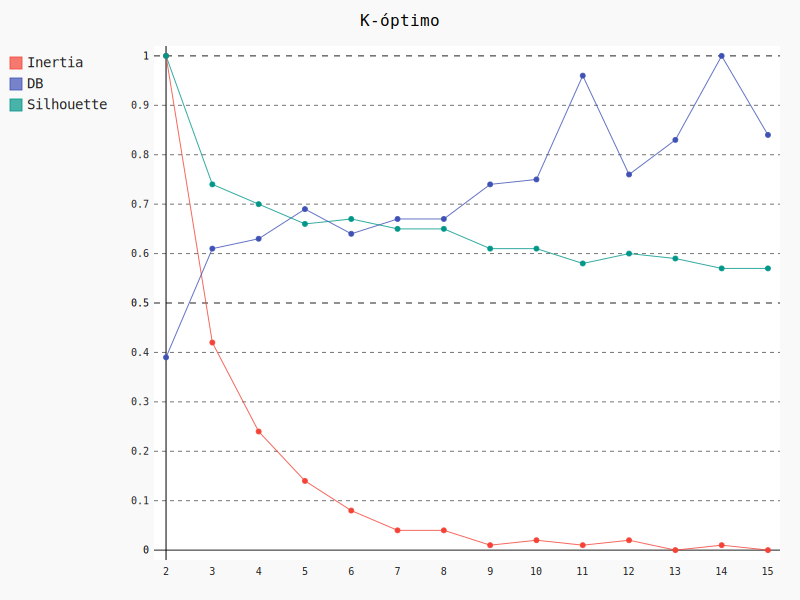

In [39]:
line_chart = koptimo(df)

In [40]:
line_chart.render_in_browser()

file:///var/folders/j4/1p33_bh96yn8pdz3b_5t80hm0000gn/T/tmptg37377j.html


### Model

Distribución de registros en los 4 clústeres


,index,cluster
3,A,0.003584
2,B,0.204301
0,C,0.516129
1,D,0.275986


Varianza explicada con 2dim: 8.2%


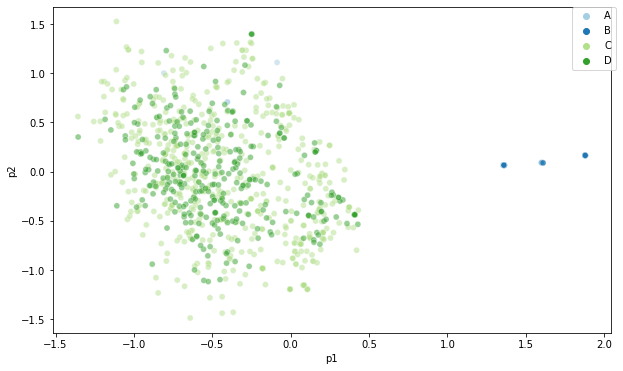

In [16]:
df = clustering(df,df.columns,n_clusters=4,kmeans=True)

### Difference between clusters

<Figure size 432x288 with 0 Axes>

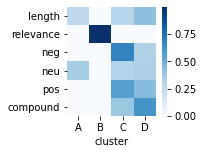

In [17]:
aux = df.iloc[:,:6].join(df['cluster'])
perfilamiento(aux)

A


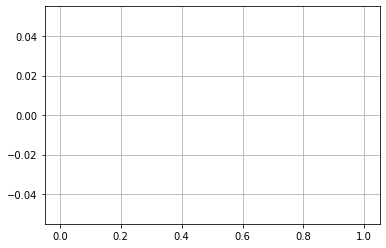

C


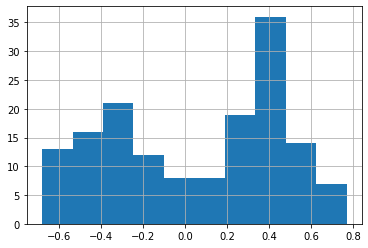

D


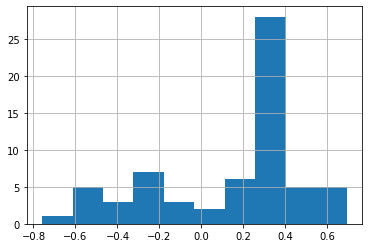

B


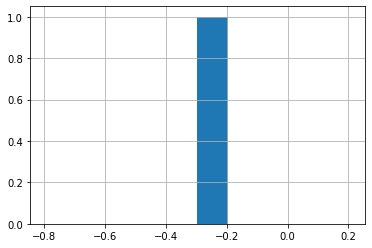

In [18]:
for cluster in set(df['cluster']):
    print(cluster)
    plt.show(df[(df['cluster']==cluster)&(df['compound']!=0)]['compound'].hist())

In [19]:
for cluster in set(df['cluster']):
    print(cluster,len(df[df['cluster']==cluster]))
    print(df[df['cluster']==cluster].index[:5])

A 4
MultiIndex([(            'the galactic council', ...),
            ('integral part of the galactic ac', ...),
            (                    'the galactic', ...),
            (                'galactic council', ...)],
           names=['clean', 'min_text'])
C 576
MultiIndex([('the last question by isaac asimov this is by far my favorite story of all those i have written', ...),
            (                                        'story and i leave it to you as to how well i succeeded', ...),
            (                             'but i won t tell you what that was lest l spoil the story for you', ...),
            (             'it is a curious fact that innumerable readers have asked me if i wrote this story', ...),
            (                                             'they seem never to remember the title of the stor', ...)],
           names=['clean', 'min_text'])
D 308
MultiIndex([(          'i undertook to tell several trillion', ...),
            ('years of human

## End

In [20]:
time_exp(time.time()-start)
tone()

0 minutos con 51.53 segundos
